12/11/2021

Rebin HST UV spectra from Sulentic+2007 and combine with their SDSS optical data where available.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from os.path import exists

import sys
#sys.path.append("/Volumes/MyPassportforMac/HST/AllHSTCode/")
sys.path.append("../../AllHSTCode/")
import Read_FOS_TVM
import Read_STIS_TVM
import Read_COS_TVM

In [2]:
def isNaN(string):
    return string != string

In [3]:
!ls ../../AllData/SulenticAllData

COS                                   Sulentic2007Info.fit
FOS                                   Sulentic2007Info_wpaths.csv
FinalPlots                            Sulentic2007Info_wpaths.csv .csv
Final_rebinned_tvm                    Sulentic2007Tables1_2.classicalRM.fit
OtherOpt                              Sulentic2007Tables1_2.fit
SDSS                                  notes_sulentic_tvm.txt
STIS                                  speclist_sdss_sulentic07.txt
Sulentic2007Info.csv                  sulentic_targets.ipynb


In [4]:
sul = pd.read_csv("../../AllData/SulenticAllData/Sulentic2007Info_wpaths.csv")
sul

,IAU,Instrument,FOS_Name,STIS_Name,COS_Name,HST_Opt,Inst_final,S2N_coadd,z,Hbeta,...,_RA,_DE,SDSS Spectra,SDSS_NAME,RA,DEC,PLATE,MJD,FIBERID,Separation
0,J12291+0203,FOS+STIS,3C273,None,None,STIS/3C273,FOS,219,0.1583,3829,...,187.277896,2.052406,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,J18421+7946,FOS+STIS,3C390,None,None,STIS/3C390,FOS,26,0.0555,12688,...,280.537458,79.771424,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,J14275+2632,FOS+STIS,J14275+2632,B21425+26,None,NaN,FOS,17,0.3634,9224,...,216.898334,26.537402,yes,142735.60+263214.5,216.898360,26.537377,2135.0,53827.0,340.0,0.121078
3,J01376-2430,STIS,None,J01376-2430,None,NaN,STIS,19,0.8350,10563,...,24.409853,-24.514971,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,J04232-0120,FOS+STIS,J04232-0120,J04232-0120,None,NaN,FOS,17,0.9150,3185,...,65.815836,-1.342518,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,J01399+0131,FOS,UM355,None,None,NaN,FOS,5.8*,0.2600,11245,...,24.988842,1.529492,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126,J13532+6345,STIS,None,PG1351+640,None,NaN,STIS,19,0.0882,5876,...,208.315980,63.762694,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127,J17046+6044,FOS+STIS,SBS1704+608,SBS1704+608,None,NaN,FOS,22,0.3720,9224,...,256.172372,60.741814,yes,170441.38+604430.5,256.172426,60.741806,353.0,51703.0,377.0,0.099728
128,J00573-2222,STIS,None,TONS180,None,NaN,STIS,26,0.0620,1131,...,14.334174,-22.382344,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
z       = sul["z"].values
sdss    = ~isNaN(sul["SDSS_NAME"].values)
plate   = sul["PLATE"].values
mjd     = sul["MJD"].values
fiber   = sul["FIBERID"].values
id_fos  = sul["FOS_Name"].values
id_stis = sul["STIS_Name"].values
id_cos = sul["COS_Name"].values

In [6]:
FOS  = sul["FOS_Name"].values!="None"
STIS = sul["STIS_Name"].values!="None"
COS  = sul["COS_Name"].values!="None"
(FOS&sdss).sum(), (STIS&sdss).sum(), (COS&sdss).sum(), ((FOS|STIS|COS)&sdss).sum()

(52, 3, 0, 53)

In [7]:
id_cos[(COS&sdss)]

array([], dtype=object)

There is one Sulentic source that only has COS data.  Will worry about that as I collect more DR16 sources for the full sample.

For now the sample I'll work with is those with either FOS or STIS data, and which have SDSS-DR16 data as well.  This gives 53 Sulentic quasars.

In [8]:
#Check if we have NecessaryParams.csv file saved for each 
N = 0
for i in range(sul[FOS].shape[0]):
    if not exists("../../AllData/SulenticAllData/FOS/%s/NecessaryParams.csv" % id_fos[FOS][i]):
    #if not exists("/Volumes/MyPassportforMac/HST/AllData/SulenticAllData/FOS/%s/NecessaryParams.csv" % id_fos[FOS][i]):
        N += 1
        print("Missing HST Observational Params for %s" % id_fos[FOS][i])
    #Read_FOS_TVM.rebin(id_fos[FOS][i], "%04d/spec-%04d-%05d-%04d.fits"%(plate[FOS][i],mjd[FOS][i],fiber[FOS][i]), z[FOS][i])
    
    
N

0

Good, should be ready to test all FOS-Sulentic spectra.  Now same thing for STIS and COS.

In [9]:
#Check if we have NecessaryParams.csv file saved for each 
N = 0
for i in range(sul[STIS].shape[0]):
    if not exists("../../AllData/SulenticAllData/STIS/%s/NecessaryParams.csv" % id_stis[STIS][i]):
    #if not exists("/Volumes/MyPassportforMac/HST/AllData/SulenticAllData/STIS/%s/NecessaryParams.csv" % id_stis[STIS][i]):
        N += 1
        print("Missing HST Observational Params for %s" % id_stis[STIS][i])
    #Read_STIS_TVM.rebin(id_stis[STIS][i], "%04d/spec-%04d-%05d-%04d.fits"%(plate[STIS][i],mjd[STIS][i],fiber[STIS][i]), z[STIS][i])
    
    
N

0

Finally.  Now the COS sources.  Should be able to use the ``all_exposures.txt`` files, but I'm not sure where they came from, so it would be tricky to fill in for those that don't have.

In [10]:
#Check if we have NecessaryParams.csv file saved for each 
N = 0
for i in range(sul[COS].shape[0]):
    if not exists("../../AllData/SulenticAllData/COS/%s/all_exposures.txt" % id_cos[COS][i]):
    #if not exists("/Volumes/MyPassportforMac/HST/AllData/SulenticAllData/COS/%s/all_exposures.txt" % id_cos[COS][i]):
        N += 1
        print("Missing HST Observational Params for %s" % id_cos[COS][i])
    #Read_COS_TVM.rebin(id_cos[COS][i], "%04d/spec-%04d-%05d-%04d.fits"%(plate[COS][i],mjd[COS][i],fiber[COS][i]), z[COS][i])
    
    
N

0

In [11]:
sdss

array([False, False,  True, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False,  True,  True, False,  True,  True,
        True,  True, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True, False, False, False,  True,  True, False,
        True,  True,  True,  True, False,  True, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True,  True, False,  True,  True,  True, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False,  True, False,  True,  True,  True,
       False,  True,  True,  True,  True, False, False, False,  True,
       False,  True,  True,  True,  True,  True,  True,  True, False,
       False,  True,

/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
../../AllHSTCode/Read_COS_TVM.py:400: RuntimeWarning: divide by zero encountered in true_divide
  my_weights[:,i] = 1 / (old_binned_errs[:,i]**2. / total_variance[i])
../../AllHSTCode/Read_COS_TVM.py:451: RuntimeWarning: divide by zero encountered in true_divide
  my_weights[:,i] = 1 / (old_binned_errs[:,i]**2 / total_variance[i])


Median wavelength resolution: 69.09 km/s
SNR is 48.080145


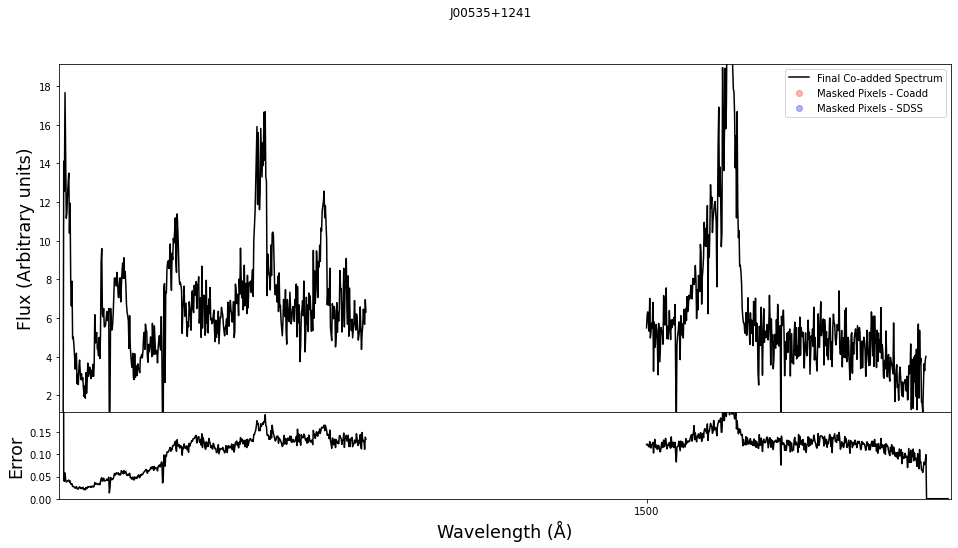

Good: J00535+1241


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
../../AllHSTCode/Read_COS_TVM.py:400: RuntimeWarning: divide by zero encountered in true_divide
  my_weights[:,i] = 1 / (old_binned_errs[:,i]**2. / total_variance[i])
../../AllHSTCode/Read_COS_TVM.py:451: RuntimeWarning: divide by zero encountered in true_divide
  my_weights[:,i] = 1 / (old_binned_errs[:,i]**2 / total_variance[i])
../../AllHSTCode/Read_COS_TVM.py:480: RuntimeWarning: divide by zero encountered in true_divide
  new_weights = 1 / (new_errs**2.)


Median wavelength resolution: 69.09 km/s
SNR is 41.561634


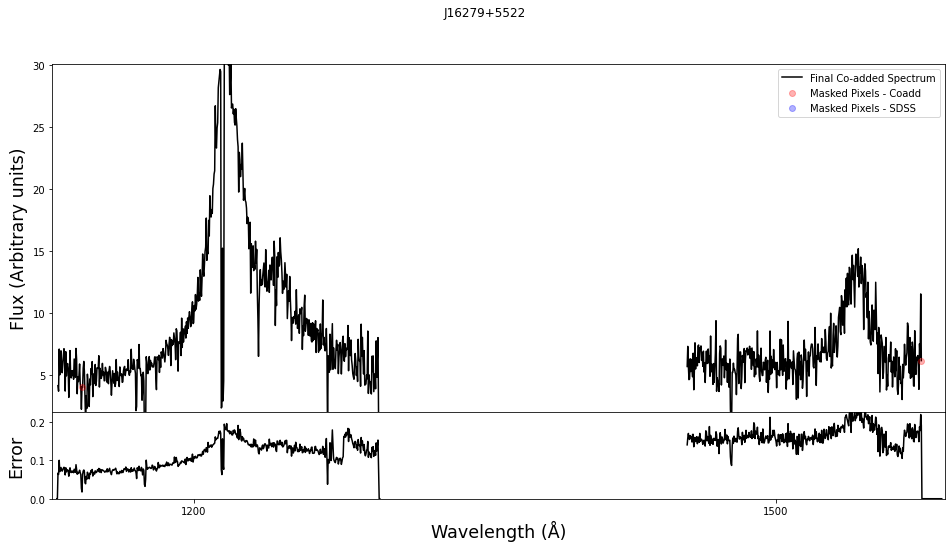

Good: J16279+5522


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
../../AllHSTCode/Read_COS_TVM.py:400: RuntimeWarning: divide by zero encountered in true_divide
  my_weights[:,i] = 1 / (old_binned_errs[:,i]**2. / total_variance[i])
../../AllHSTCode/Read_COS_TVM.py:451: RuntimeWarning: divide by zero encountered in true_divide
  my_weights[:,i] = 1 / (old_binned_errs[:,i]**2 / total_variance[i])
../../AllHSTCode/Read_COS_TVM.py:480: RuntimeWarning: divide by zero encountered in true_divide
  new_weights = 1 / (new_errs**2.)


Median wavelength resolution: 69.09 km/s
SNR is 91.313143


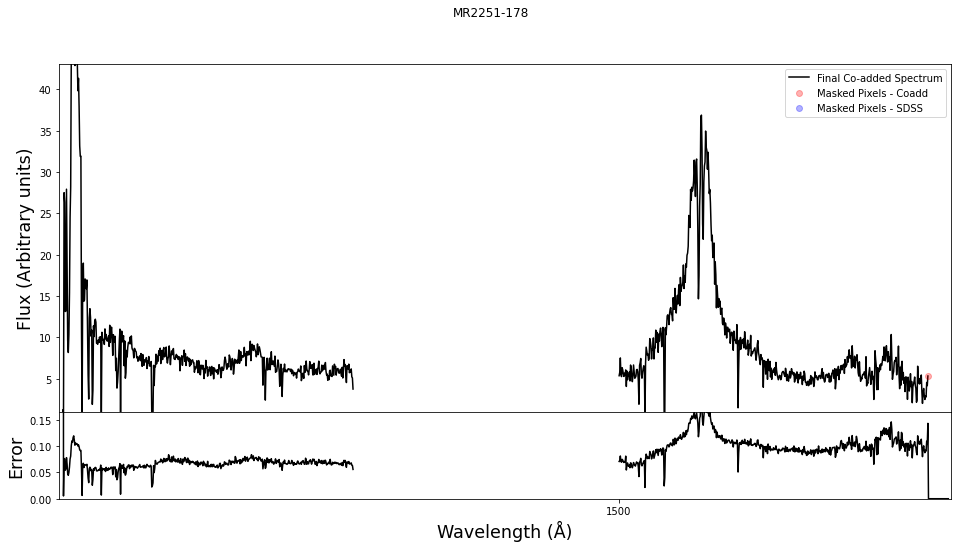

Good: MR2251-178


In [12]:
#%%capture
for i in range(sul[COS].shape[0]):
    if sdss[COS][i]: fn_sdss = "%04d/spec-%04d-%05d-%04d.fits"%(plate[COS][i],plate[COS][i],mjd[COS][i],fiber[COS][i])
    else: fn_sdss = None
    try:
        Read_COS_TVM.rebin(id_cos[COS][i], fn_sdss, z[COS][i])
        print("Good: %s" % id_cos[COS][i])
    except IndexError:
        print("Index Error: %s" % id_cos[COS][i])
        #except ValueError:
        #    print("%s doesn't work"%id_cos[COS][i])
    except ValueError:
        print("Value Error: %s" % id_cos[COS][i])

---

The code pretty good, but bad edge pixels are messing up the final co-add.  Need to manually adjust a line of code in ``Cut_Edge_Pix_TVM.py``: change ``all_snrs>X`` in ``good_mask``.

- J16279+5522
- J00535+1241
- MR2251-178